## 1. Set up communication with the FR3

### 1.1 Set up communication with the arm

In [1]:
%load_ext autoreload
%autoreload 2
import sys 
from FR3Py.robot.interface import FR3Real
robot = FR3Real(robot_id='fr3')

Interface Running...


In [2]:
# Print the arm state
robot.getJointStates()

{'q': array([ 3.28444994e-04, -7.85749027e-01, -1.70123662e-04, -2.35641295e+00,
        -7.01214304e-04,  1.57099311e+00,  7.84952844e-01]),
 'dq': array([ 2.95557798e-04,  5.26100404e-04, -7.52277401e-04,  1.47901472e-03,
        -1.54088850e-03, -9.59003136e-05,  8.25924372e-04]),
 'T': array([-0.21097112, -3.84179831, -0.59706724, 22.94101334,  1.16014326,
         2.13498664,  0.18633488]),
 'M': array([[ 4.83362175e-01, -9.52153094e-03,  4.80469628e-01,
         -1.24942281e-02,  5.54493868e-02, -3.84493482e-03,
          1.56537641e-03],
        [-9.52153094e-03,  1.53787873e+00,  5.24213776e-03,
         -6.90818408e-01, -1.43550279e-02, -2.38349209e-02,
         -6.81733598e-04],
        [ 4.80469628e-01,  5.24213776e-03,  9.85185426e-01,
         -2.77046186e-02,  6.82295770e-02, -4.61720922e-03,
          3.48924037e-03],
        [-1.24942281e-02, -6.90818408e-01, -2.77046186e-02,
          9.51032696e-01,  2.77312769e-02,  1.06067345e-01,
          3.14960224e-04],
        

# 2. Go to initial joint angle

In [12]:
import numpy as np
import time

In [13]:
## Some global parameters
joint_lb = np.array([-2.3093, -1.5133, -2.4937, -2.7478, -2.48, 0.8521, -2.6895])
joint_ub = np.array([2.3093, 1.5133, 2.4937, -0.4461, 2.48, 4.2094, 2.6895])
joint_vel_lb = -np.array([2.175, 2.175, 2.175, 2.175, 2.61, 2.61, 2.61])
joint_vel_ub = np.array([2.175, 2.175, 2.175, 2.175, 2.61, 2.61, 2.61])

In [14]:
T = 7
q_init = np.array([ 1.0582, -1.3811,  0.3629, -1.9647, -0.959,   1.4881, -0.1534])

Kp_joint = np.diag([1, 1, 1, 1, 4, 2, 1])*5
t_start = time.time()
while time.time() - t_start < T:
    robot_info = robot.getJointStates()
    q = robot_info['q'] # shape (7,)
    
    W = np.diag(1.0/(joint_ub-joint_lb))
    eq = W @ (q - q_init)
    dq = - Kp_joint @ eq
    dq = np.clip(dq, joint_vel_lb, joint_vel_ub)
    robot.setCommands(dq)

robot.setCommands(np.zeros_like(dq))

# 3. uaibot

In [15]:
import uaibot as ub
from create_franka_emika_3_mod import *

##############################################################################
#Create list of obstacles
obstacles = []
obstacles.append(ub.Box(htm = ub.Utils.trn([0.52, 0.19, 0.48]), width=0.32,depth=0.08,height=0.92,color='magenta'))
obstacles.append(ub.Box(htm = ub.Utils.trn([0.52,-0.19, 0.48]), width=0.32,depth=0.08,height=0.92,color='magenta'))
obstacles.append(ub.Box(htm = ub.Utils.trn([0.52, 0.00, 0.96]), width=0.32,depth=0.46,height=0.08,color='magenta'))

##############################################################################
#Create the robot
uai_robot = create_franka_emika_3_mod()
no_joint = np.shape(uai_robot.q)[0]

##############################################################################
#Create the target pose
htm_tg = ub.Utils.trn([0.64,0,0.75])*ub.Utils.roty(np.pi/2)*ub.Utils.rotz(np.pi/2)

In [18]:
#Parameters
#Control parameters
K = 2*np.diag([0.2,0.2,0.2,0.2,0.2,0.2])
eta = 0.2*0+0.5

#mode = 0 (Euclidean)
#mode = 1 (Smoothed)
mode = 0

if mode == 0:
    h=1e-6
    eps=0
    delta=0.03
else:
    h=0.1
    eps=0.01
    delta=0.002

In [19]:
# Main control loop
timestamps_list = [] 
joint_angles_list = []
control_list = []
time_per_loop_list = []

T = 20
start_time = time.time()
while (time.time() - start_time < T):
    loop_start = time.time()
    robot_info = robot.getJointStates()
    #Get current configuration, in the real robot you have to measure this from somewhere
    q = robot_info["q"].reshape(-1,1)

    #Compute task function and Jacobian at current configuration
    r, jac_r = uai_robot.task_function(q=q, htm_tg=htm_tg)
    
    #GATHER DATA FOR THE OBSTACLE AVOIDANCE CONSTRAINT
    #Loop all the obstacles and compute distance info
    mat_A = np.matrix(np.zeros((0,7)))
    mat_b = np.matrix(np.zeros((0,1)))
    
    true_dist = 1000
    for obs in obstacles:
        dr = uai_robot.compute_dist(q=q, obj=obs, h=h, eps=eps)
        mat_A = np.vstack((mat_A, dr.jac_dist_mat))
        mat_b = np.vstack((mat_b, -eta*(dr.dist_vect-delta)))
        
        true_dist = min(true_dist, uai_robot.compute_dist(q=q,obj=obs).get_closest_item().distance)
        
    #GATHER DATA FOR THE JOINT LIMIT AVOIDANCE COINSTRANT
    mat_A = np.vstack((mat_A, np.identity(7)))
    mat_b = np.vstack((mat_b, -eta*(q-uai_robot.joint_limit[:,0])))
    
    mat_A = np.vstack((mat_A,-np.identity(7)))
    mat_b = np.vstack((mat_b,-eta*(uai_robot.joint_limit[:,1]-q)))
    
    #CREATE THE QUADRATIC PROGRAM    
    r, jac_r = uai_robot.task_function(q=q, htm_tg=htm_tg)
    mat_H = jac_r.T*jac_r + 0.01*np.identity(7)
    mat_f = jac_r.T*(K*r)
        
    #Compute qdot
    dq = ub.Utils.solve_qp(mat_H, mat_f, mat_A, mat_b)
    dq = np.array(dq)
    dq = dq.squeeze(-1)
    dq = np.clip(dq, joint_vel_lb, joint_vel_ub)
    # dq = np.zeros_like(dq)
    robot.setCommands(dq)
    loop_end = time.time()

    timestamps_list.append(loop_start)
    joint_angles_list.append(robot_info["q"].copy())
    control_list.append(dq.copy())
    time_per_loop_list.append(loop_end-loop_start)

robot.setCommands(np.zeros_like(dq))
    

# 4. Save the data

In [20]:
import pickle
from datetime import datetime
import os

now = datetime.now()
formatted_date_time = now.strftime("%Y-%m-%d-%H-%M-%S")

directory = f"exp5_results/{formatted_date_time}"

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Define the file path
file_path = os.path.join(directory, "data.pickle")

# Data to be saved
data = {
    "q": joint_angles_list,
    "dq": control_list,
    "timestamp": timestamps_list,
    "time_per_loop": time_per_loop_list
}

# Save the data using pickle
with open(file_path, "wb") as f:
    pickle.dump(data, f)

# 5. Visualization

In [10]:
import matplotlib.pyplot as plt

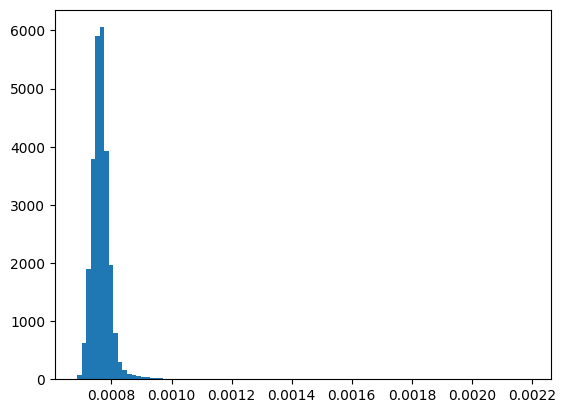

In [11]:
time_per_loop_np = np.array(time_per_loop_list)
plt.hist(time_per_loop_np, bins=100)
plt.show()